# **1. 모델 설계**

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


데이터 다운: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hoonestly","key":"78e0cdcb1e9c01e294e58f4540e8cf8c"}'}

In [4]:
ls -1ha kaggle.json

kaggle.json


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d dansbecker/cityscapes-image-pairs

Dataset URL: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs
License(s): other
100% 201M/202M [00:11<00:00, 21.7MB/s]
100% 202M/202M [00:11<00:00, 18.1MB/s]


In [7]:
!ls

cityscapes-image-pairs.zip  drive  kaggle.json	sample_data


In [8]:
!unzip cityscapes-image-pairs.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: cityscapes_data/cityscapes_data/train/2754.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2755.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2756.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2757.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2758.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2759.jpg  
  inflating: cityscapes_data/cityscapes_data/train/276.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2760.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2761.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2762.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2763.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2764.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2765.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2766.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2767.jpg  
  inflating: cityscapes_data/citysc

In [9]:
import os

root_path = '/content/cityscapes_data'

data_dir = root_path
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

2975 500


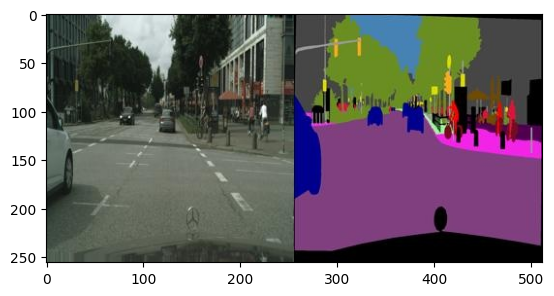

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")

plt.imshow(sample_image)
plt.show()

In [11]:
import numpy as np
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)

(1000, 3)


In [12]:
from sklearn.cluster import KMeans
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

In [13]:
def split_image(image) :
   image = np.array(image)
   cityscape, label = image[:, :256, :], image[:, 256:, :]
   return cityscape, label

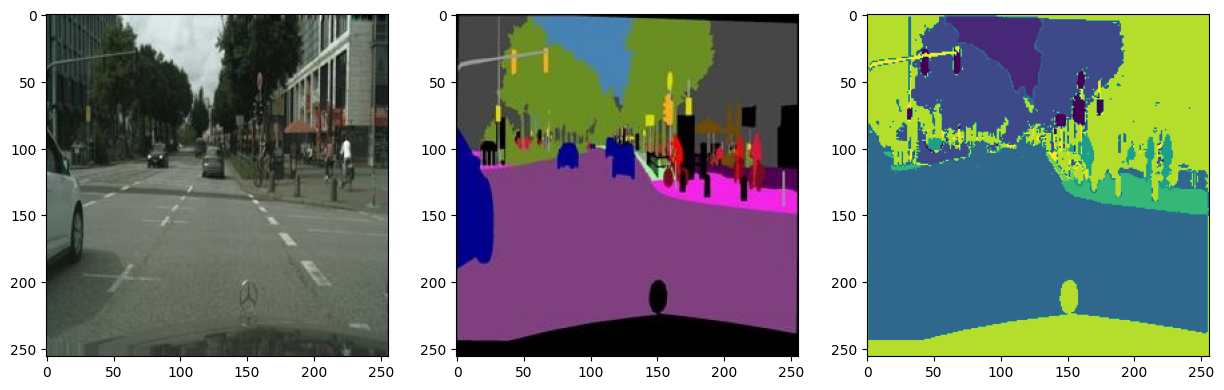

In [14]:
cityscape, label = split_image(sample_image)

label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

plt.show()

In [15]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self) :
    return len(self.image_fns)

  def __getitem__(self, index) :
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp)
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image) :
    image = np.array(image)
    cityscape, label = image[ : , :256, : ], image[ : , 256: , : ]
    return cityscape, label

  def transform(self, image) :
    transform_ops = transforms.Compose([
      			transforms.ToTensor(),
                        transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

cityscape, label_class = dataset[0]
print(cityscape.shape)
print(label_class.shape)

2975
torch.Size([3, 256, 256])
torch.Size([256, 256])


In [16]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.dec4 = self.conv_block(1024, 512)
        self.dec3 = self.conv_block(512, 256)
        self.dec2 = self.conv_block(256, 128)
        self.dec1 = self.conv_block(128, 64)

        # Final Convolution Layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up_conv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, X):
        # Encoder Path
        enc1_out = self.enc1(X)
        enc2_out = self.enc2(self.max_pool(enc1_out))
        enc3_out = self.enc3(self.max_pool(enc2_out))
        enc4_out = self.enc4(self.max_pool(enc3_out))

        # Bottleneck
        bottleneck_out = self.bottleneck(self.max_pool(enc4_out))

        # Decoder Path
        dec4_out = self.dec4(torch.cat((self.up_conv4(bottleneck_out), enc4_out), dim=1))
        dec3_out = self.dec3(torch.cat((self.up_conv3(dec4_out), enc3_out), dim=1))
        dec2_out = self.dec2(torch.cat((self.up_conv2(dec3_out), enc2_out), dim=1))
        dec1_out = self.dec1(torch.cat((self.up_conv1(dec2_out), enc1_out), dim=1))

        # Final Output
        output = self.final_conv(dec1_out)

        return output

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

model = UNet(num_classes=num_classes)
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape)
print(Y.shape)

2975 744
torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])


In [18]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


# **2. 모델 학습**

In [20]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 하이퍼파라미터 자율설정

batch_size = 16

epochs = 3
lr = 0.001

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

model = UNet(num_classes = num_classes).to(device)

# 손실함수 정의
criterion = nn.CrossEntropyLoss()
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), lr = lr)


step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)) :
  epoch_loss = 0

  for X, Y in tqdm(data_loader, total = len(data_loader), leave = False) :
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

100%|██████████| 3/3 [07:55<00:00, 158.48s/it]


In [21]:
print(len(epoch_losses))
print(epoch_losses)

3
[0.8696438352907857, 0.5991974170169523, 0.5319606549637292]


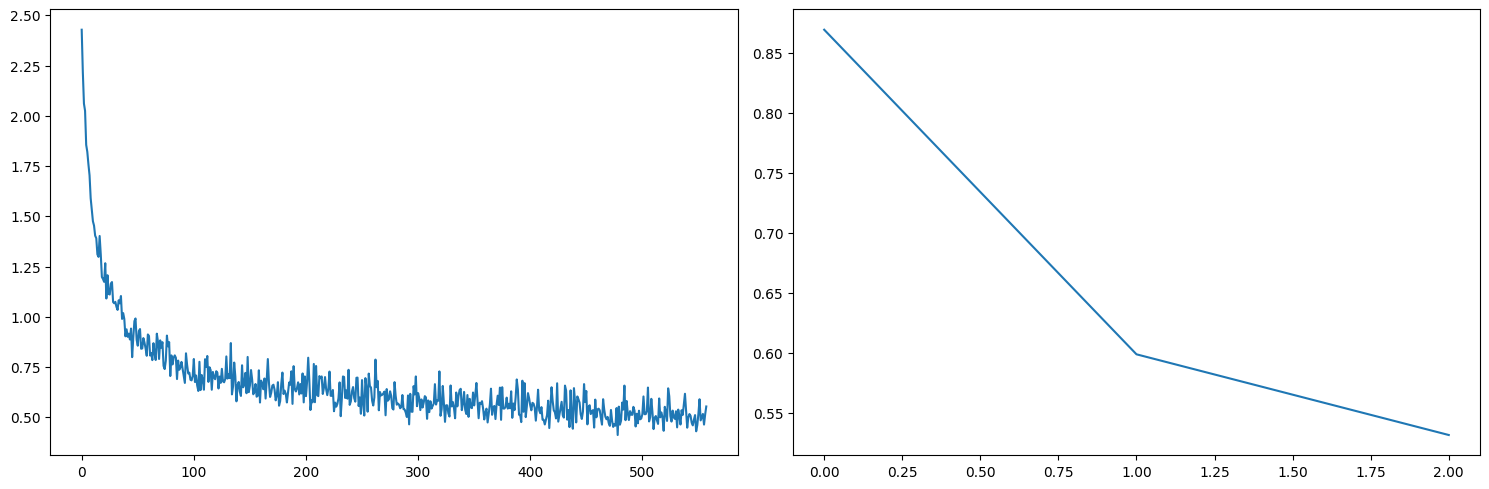

In [32]:
# Loss plot with detailed subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot for training loss per batch
axes[0].plot(step_losses)

# Plot for epoch loss
axes[1].plot(epoch_losses)

plt.tight_layout()
plt.show()

In [23]:
model_name = "UNet.pth"
torch.save(model.state_dict(), root_path + model_name)

# **3. 모델 평가**

In [24]:
model_path = root_path + model_name
model_ = UNet(num_classes = num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<ipython-input-24-3aae70c58793>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [25]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size = test_batch_size)

X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


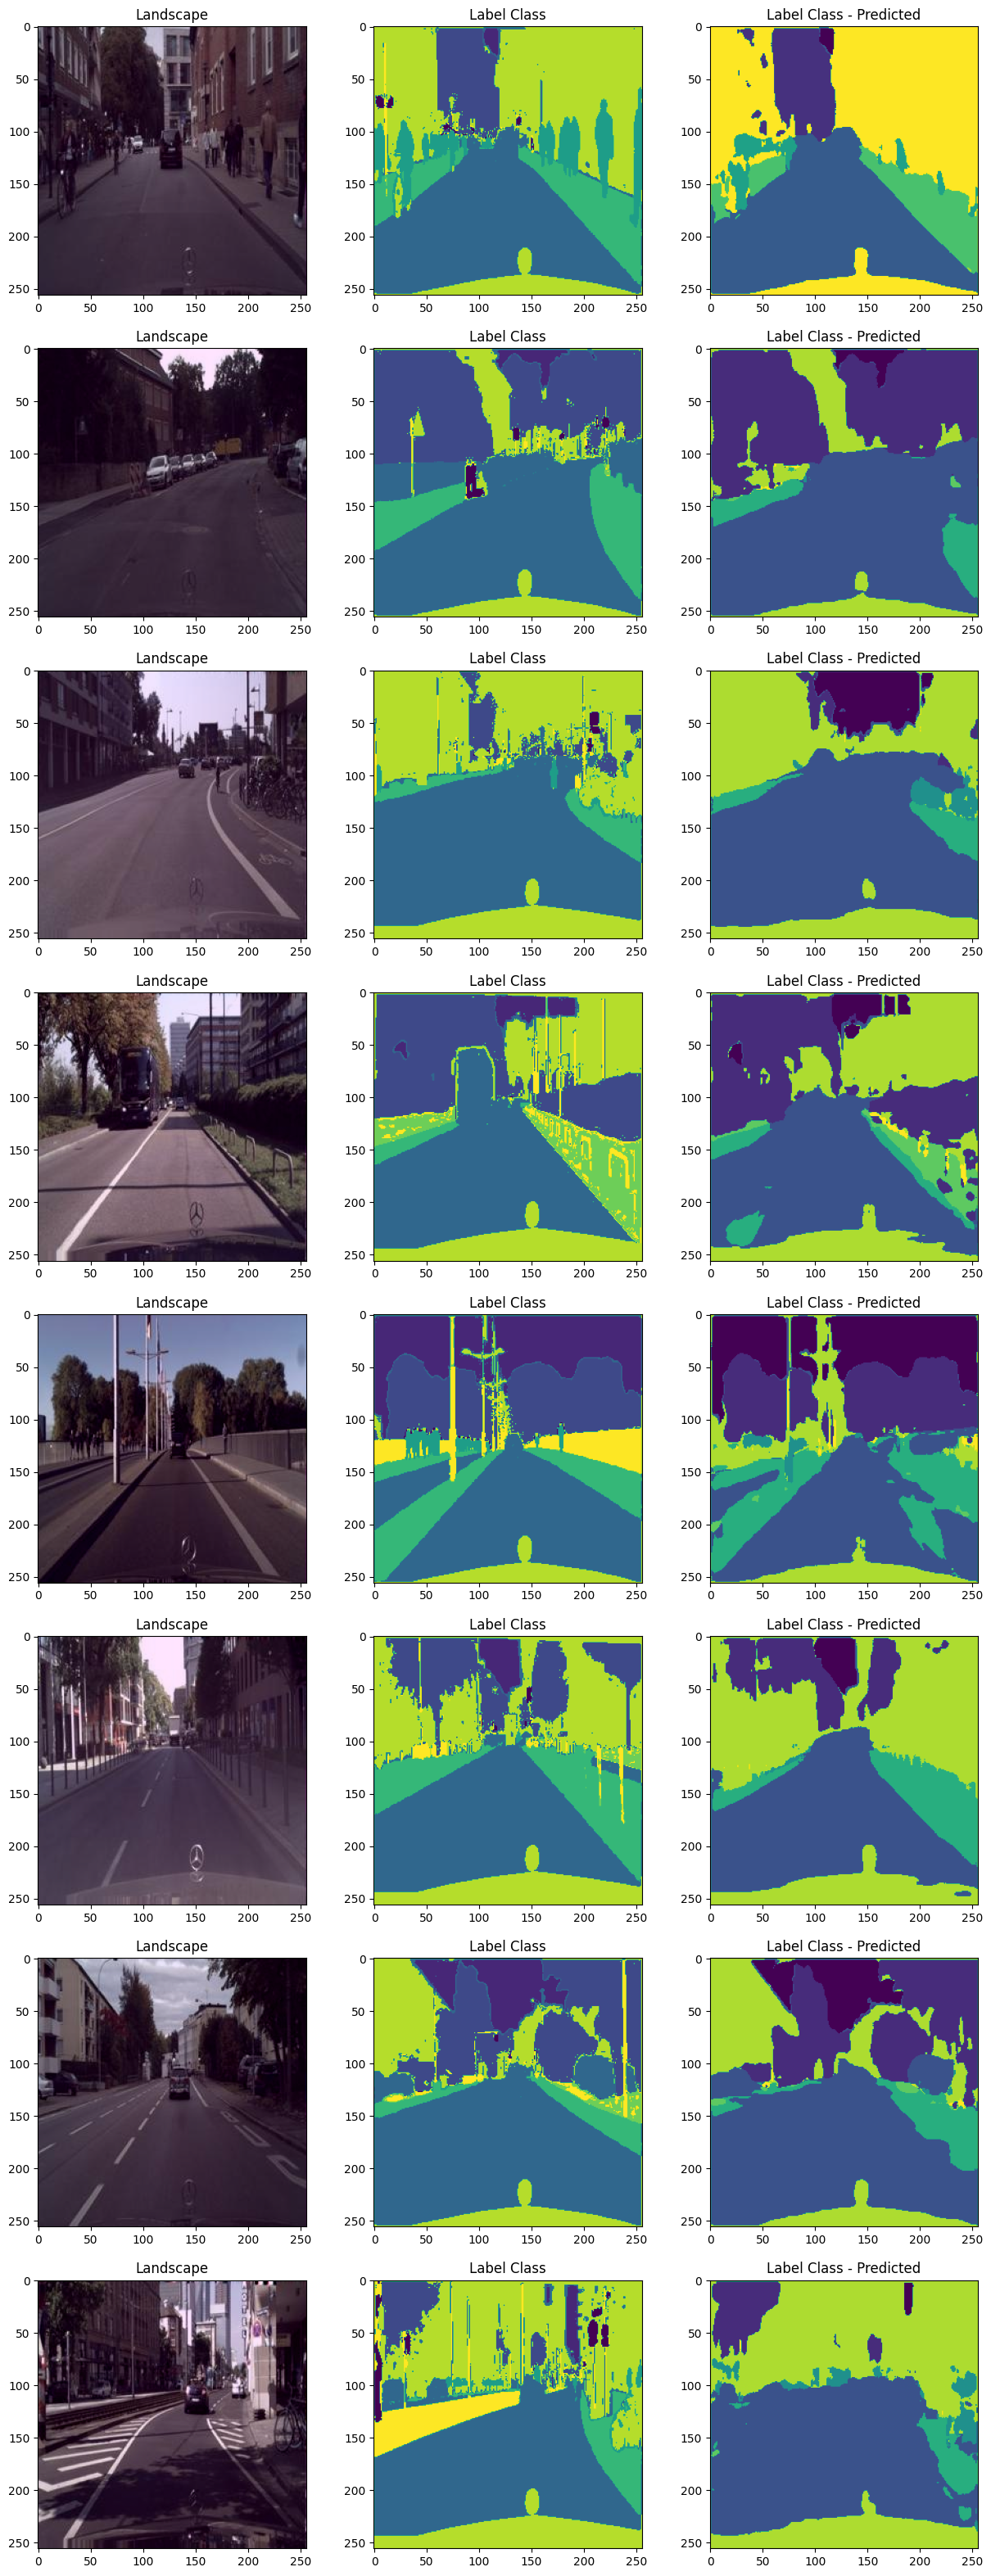

In [26]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

plt.show()

# **4. IoU Score**

In [34]:
mean_iou = sum(iou_scores) / len(iou_scores)
print(f"Mean IoU: {mean_iou:.4f}")


Mean IoU: 0.9952
